In [1]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web # 주식 데이터를 얻어오기 위해 사용
import datetime # 시간 처리
import matplotlib.pyplot as plt
import yfinance as yf
import FinanceDataReader as fdr
from prophet import Prophet
%matplotlib inline

# 데이터를 가져오고 나서, 이동평균을 구해야함.
# 국내 종목 : 삼성전자

# 날짜 : 3년 간 삼성전자 주가 분석(2017.01.02) ~ (2021.06.07)
start = datetime.datetime( 2021, 3, 25 )
end = datetime.datetime( 2024, 3, 25)

C:\Users\chan\anaconda3\envs\ng\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


s&p500사용

In [2]:
# sp_df = fdr.StockListing('S&P500')
# sp_name = sp_df['Symbol']

In [2]:
def makeStockChart(code, sDay, eDay):
    """
    이 함수는 종목코드와 조회 시작일, 종료일을 넣으면 차트를 그려준다.
    이동 평균선은 5일, 20일, 60일, 120일을 지원한다.
    """
    
    # 데이터 가져오기
    data = yf.download(code, start=sDay, end=eDay)
    
    # 이동 평균 계산
    data['5MA'] = data['Adj Close'].rolling(window=5).mean()
    data['20MA'] = data['Adj Close'].rolling(window=20).mean()
    data['60MA'] = data['Adj Close'].rolling(window=60).mean()
    data['120MA'] = data['Adj Close'].rolling(window=120).mean()
    
    # 차트 그리기
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close')
    plt.plot(data['5MA'], label='5MA')
    plt.plot(data['20MA'], label='20MA')
    plt.plot(data['60MA'], label='60MA')
    plt.plot(data['120MA'], label='120MA')
    plt.title(f"{code}'s Stock Chart")
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


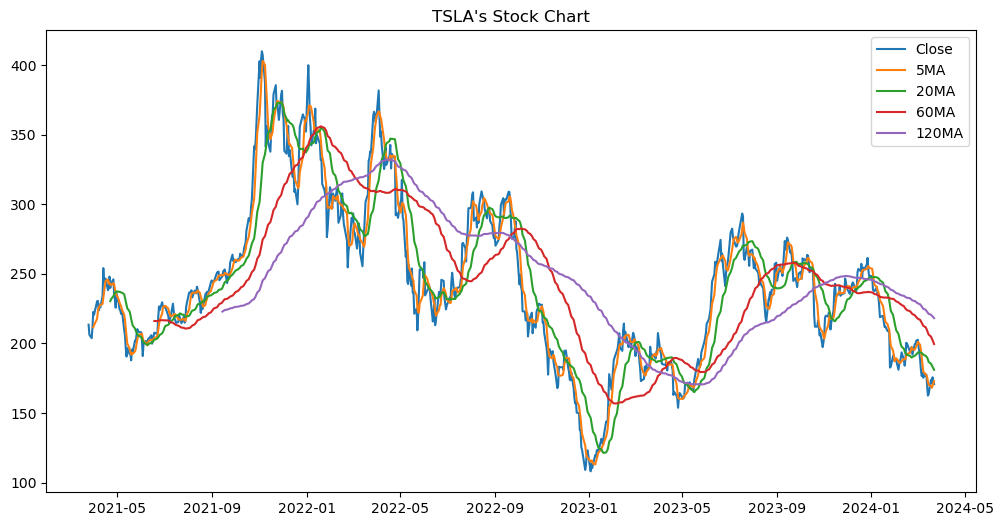

In [13]:
code_name = 'TSLA'
makeStockChart(code_name, start, end)

In [14]:
datas = yf.download(code_name, start=start, end=end)

# 컬럼 ds(YYYY-MM-DD), y(종가 : Close) 구성
# 해당 구저의 DateFrame만들기 위한 딕셔너리 선언

dic = {
    'ds' : datas.index,
    'y' : datas.Close
}

# ds 와 y를 컬럼으로 갖는 데이터 프레임 생성
df = pd.DataFrame( dic )

#인덱스 초기화(원본 까지 적용)
df.reset_index( inplace=True )

# 'ds' 컬럼과 중복되는 'Date' 컬럼 제거
del df['Date']

# 페이스북의 시계열 예측 모델에 사용한 데이터 준비
df.head(5)

[*********************100%%**********************]  1 of 1 completed


,ds,y
0,2021-03-25,213.463333
1,2021-03-26,206.236664
2,2021-03-29,203.763336
3,2021-03-30,211.873337
4,2021-03-31,222.643326


In [6]:
# pip install prophet

            ds        yhat  yhat_lower  yhat_upper
753 2024-03-22  206.877804  172.555495  243.012035
754 2024-03-23  211.456823  175.465272  245.179296
755 2024-03-24  214.363753  179.166919  250.966841
756 2024-03-25  217.577877  183.160751  252.099471
757 2024-03-26  219.223573  186.273729  252.429205
758 2024-03-27  222.150298  187.175149  256.307109
759 2024-03-28  223.345307  188.802541  259.973190
760 2024-03-29  225.280254  189.434695  262.689697
761 2024-03-30  228.814816  195.187970  264.978448
762 2024-03-31  230.488308  195.033706  266.510995
763 2024-04-01  232.307183  195.000023  267.272793


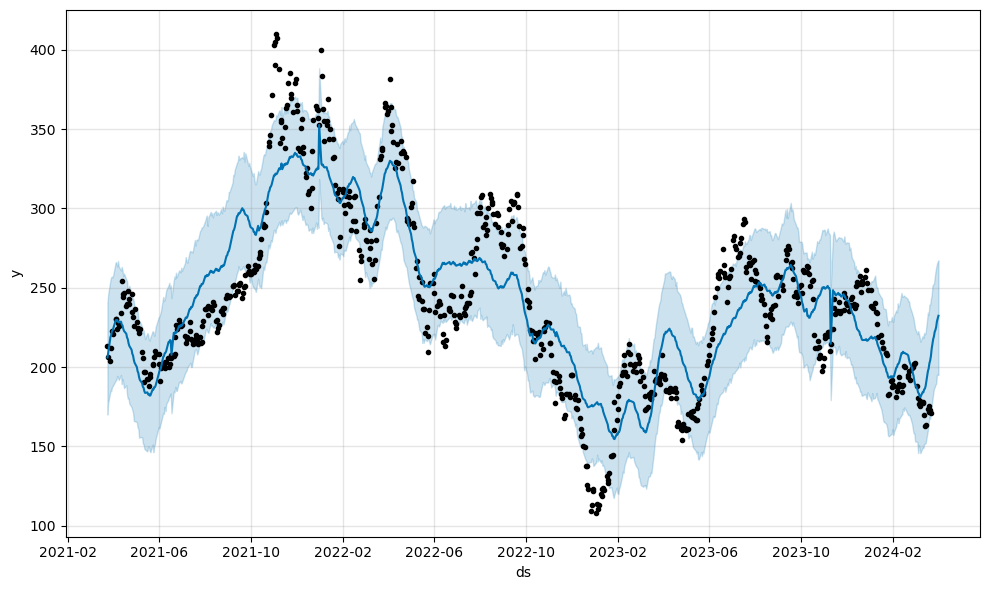

In [15]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
model = Prophet( daily_seasonality=True,
               ) 
model.add_country_holidays(country_name='US')

# 데이터 학습 시작 -> 기계학습
model.fit( df )

# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값
future = model.make_future_dataframe( periods = 10)

# 주가 예측
forecast = model.predict( future )

# forecast.columns ->
'''
  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
''' 

# 모델 예측 결과 출력
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# 모델 예측 그래프 출력
fig = model.plot(forecast)

plt.show(fig)


In [8]:
# import logging
# logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# # Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
# model = Prophet( daily_seasonality=True,
#                 seasonality_prior_scale=15,
#                 changepoint_prior_scale=0.1,
#                 interval_width=0.95
#                ) 
# model.add_country_holidays(country_name='US')

# # 데이터 학습 시작 -> 기계학습
# model.fit( df )

# # 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값
# future = model.make_future_dataframe( periods = 0)

# # 주가 예측
# forecast = model.predict( future )

# # forecast.columns ->
# '''
#   Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
#        'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
#        'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
#        'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
#        'multiplicative_terms', 'multiplicative_terms_lower',
#        'multiplicative_terms_upper', 'yhat'],
#       dtype='object')
# ''' 

# # 모델 예측 결과 출력
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# # 모델 예측 그래프 출력
# fig = model.plot(forecast)

# plt.show(fig)


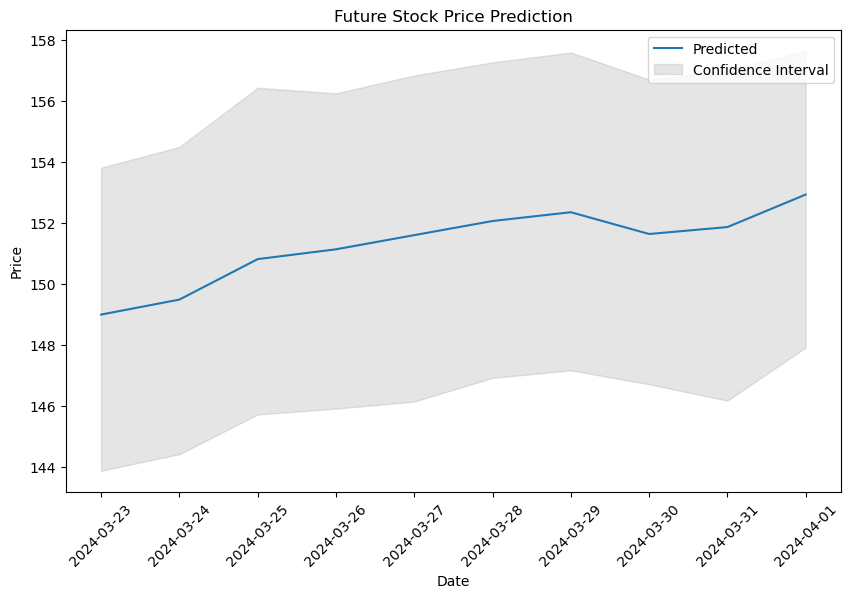

In [6]:
import matplotlib.pyplot as plt

# 기존 데이터의 마지막 날짜 찾기
last_date = df['ds'].max()

# forecast 데이터프레임에서 기존 데이터의 마지막 날짜 이후 부분만 필터링
future_forecast = forecast[forecast['ds'] > last_date]

# 필터링된 향후 예측값만 시각화
plt.figure(figsize=(10, 6))
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')

plt.title('Future Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # 날짜 라벨을 45도 회전하여 겹침 방지
plt.show()


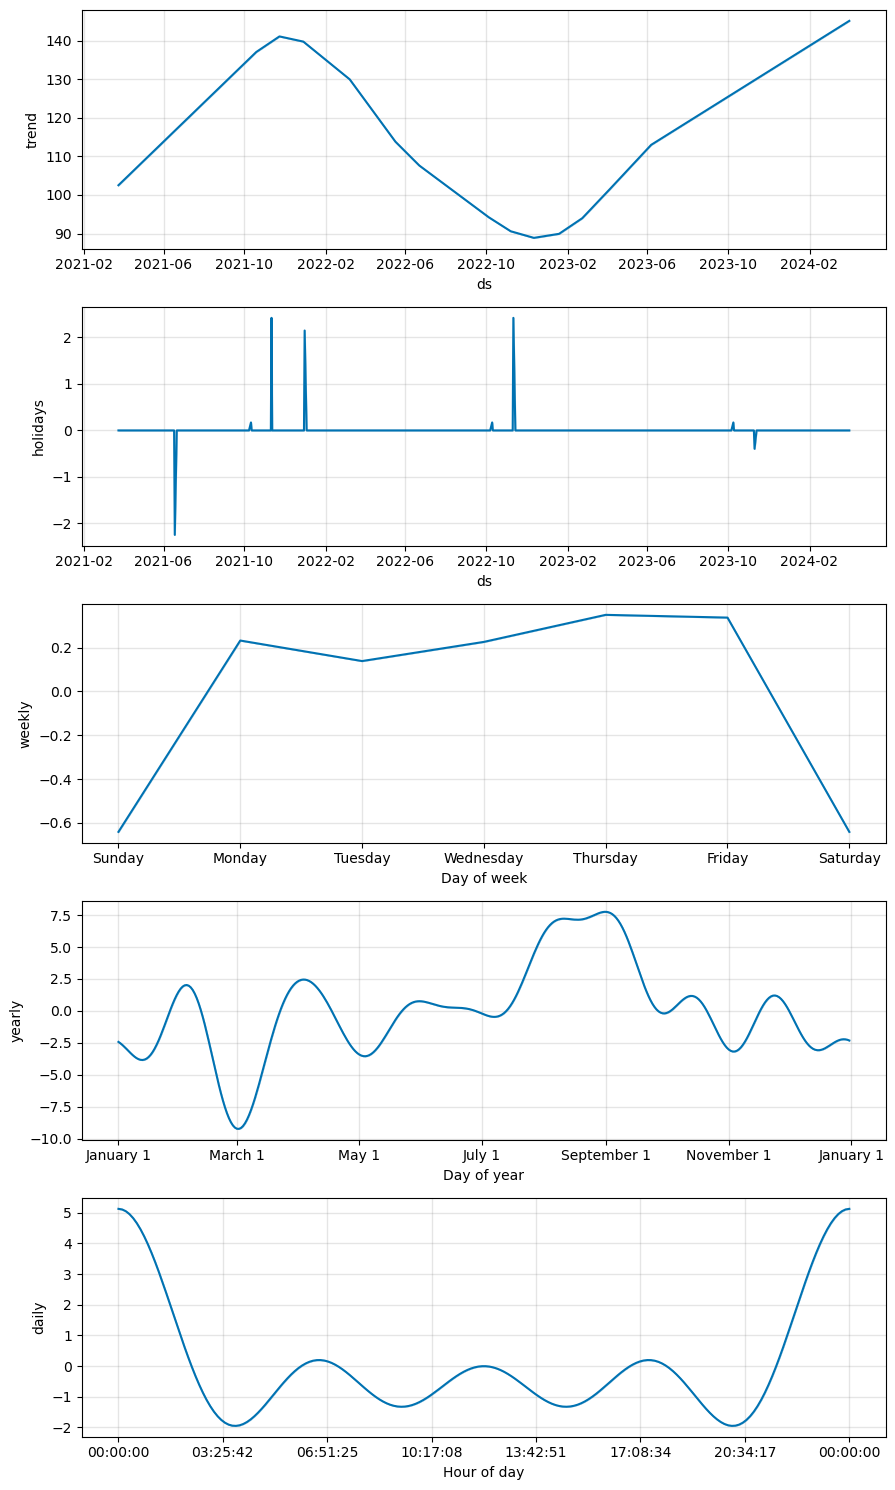

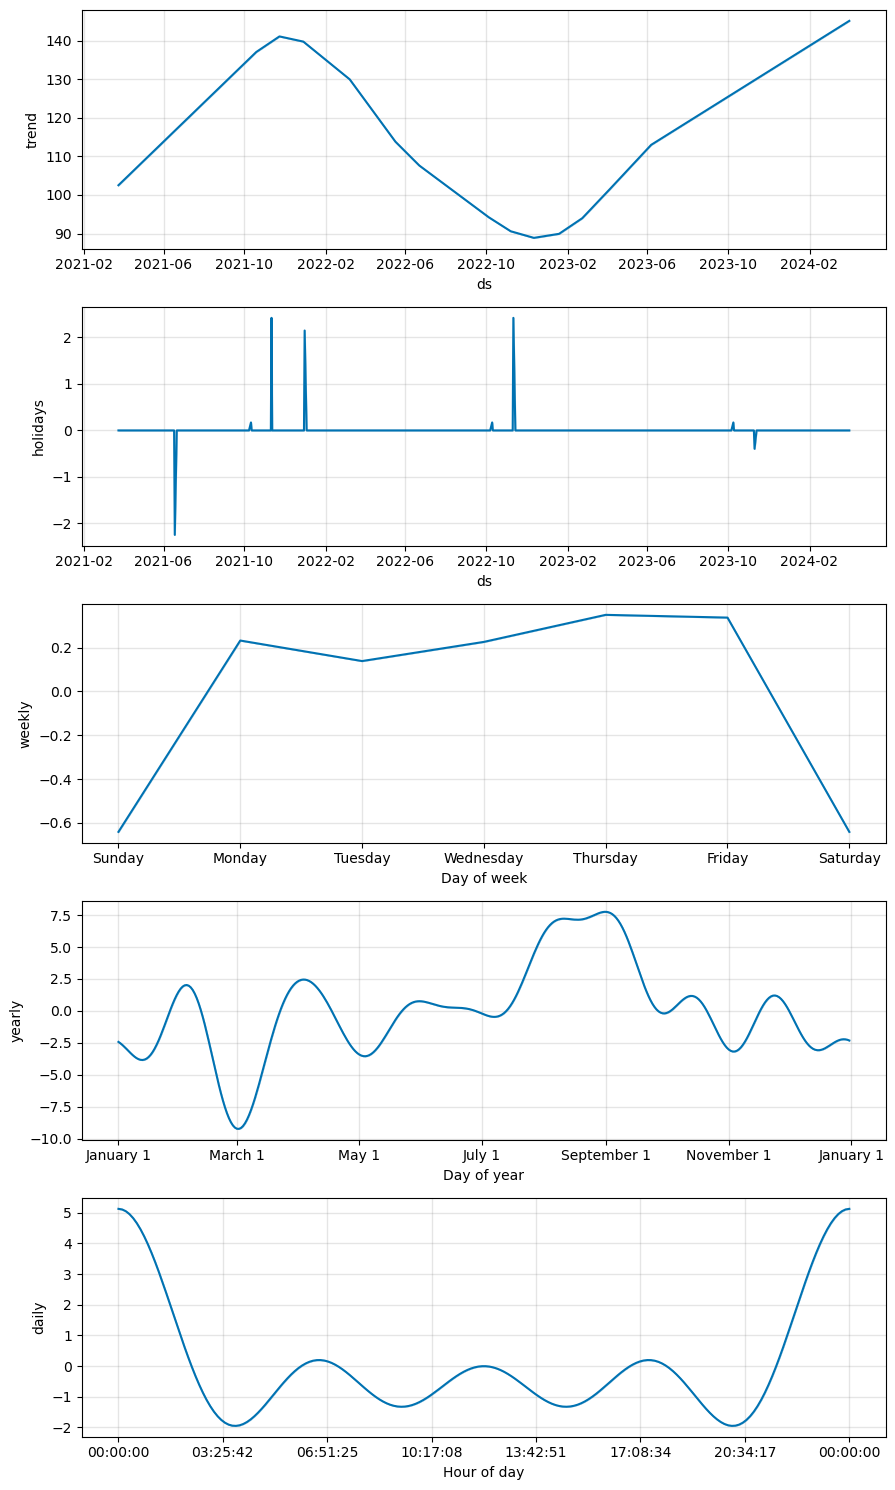

In [10]:
model.plot_components( forecast )

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 실제 값과 예측 값을 필터링하여 준비
# df 데이터프레임에서 실제 'y' 값을 가져오고, 이를 forecast 데이터프레임의 'ds'에 맞춥니다.
actual = df.set_index('ds')['y']
predictions = forecast.set_index('ds')['yhat'].reindex(actual.index)

# 평균 절대 오차(MAE)
mae = mean_absolute_error(actual, predictions)

# 평균 제곱 오차(MSE)
mse = mean_squared_error(actual, predictions)

# 결정계수(R²)
r2 = r2_score(actual, predictions)

# 결과 출력
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


MAE: 22.802475008426473
MSE: 762.6350221076106
R²: 0.7632255309775968


In [17]:
def calculate_accuracy(forecasted, actual, tolerance_percentage=10):
    # 둘 중 더 작은 길이를 가지는 데이터셋 길이를 사용하여 길이가 맞지 않는 문제 해결
    min_length = min(len(forecasted), len(actual))
    forecasted = forecasted[:min_length]
    actual = actual[:min_length]
    
    # 실제값에 대한 예측값의 허용 오차 범위를 계산
    tolerance = tolerance_percentage / 100.0
    # 실제 값과 예측 값의 차이의 비율을 계산
    differences = np.abs(forecasted - actual) / actual
    # 허용 오차 내의 정확한 예측의 비율을 계산
    accurate_predictions = differences <= tolerance
    # 정확도를 계산
    accuracy = np.mean(accurate_predictions)
    
    return accuracy
forecasted_prices = forecast['yhat'].values
actual_prices = df['y'].values

# 정확도 계산 (예: 실제값 대비 ±10% 범위 내의 예측을 정확한 것으로 간주)
accuracy = calculate_accuracy(forecasted_prices, actual_prices, tolerance_percentage=1)

print(f"정확도 (±1% 범위 내): {accuracy * 100:.2f}%")

정확도 (±1% 범위 내): 7.16%


In [13]:
# len(actual_prices)

In [14]:
# predicted_prices

In [31]:
initial_capital = 1000.0  # 초기 자본
current_capital = initial_capital  # 현재 자본, 거래 과정에서 업데이트됨
shares_owned = 0
position = 'None'  # 현재 포지션 상태
day = 180
month_day = 30
# 시뮬레이션 수익 계산
profit = 0.0

actual_prices = df.set_index('ds')['y'][-(day+31):-(day)]  # 마지막 31일 실제 가격
predicted_prices = forecast.set_index('ds')['yhat'][-(day+31):-(day)]

dates = [actual_prices.index[0] - pd.Timedelta(days=1)]  # 첫 거래일 이전 날짜 추가
capitals = [initial_capital]

# 날짜와 함께 매도, 매수, 보유 결과를 출력하기 위해 수정
for i in range(month_day):
    today_date = actual_prices.index[i]
    today_price = actual_prices.iloc[i]
    predicted_next_day_price = predicted_prices.iloc[i]

    # 조건을 검사하고 매수, 매도, 보유를 결정
    if i < (month_day-1):  # 마지막 날짜를 제외한 모든 날에 대해 검사
        next_day_price = actual_prices.iloc[i+1]
        predicted_change = predicted_next_day_price - today_price

        # 매수 조건
        if predicted_change > 0 and position != 'Hold':
            shares_owned = current_capital / today_price
            current_capital = 0
            position = 'Hold'
            print(f"{today_date} - 매수: {today_price} (실제 다음날 가격: {next_day_price:,.3f}, 예측된 다음날 가격: {predicted_next_day_price:,.3f})")

        # 매도 조건
        elif predicted_change < 0 and position == 'Hold':
            current_capital = shares_owned * next_day_price
            shares_owned = 0
            position = 'None'
            print(f"{today_date} - 매도: {next_day_price} (실제 다음날 가격: {next_day_price:,.3f}, 예측된 다음날 가격: {predicted_next_day_price:,.3f})")

        # 보유 조건
        elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
            print(f"{today_date} - 보유: {today_price}")
        else:
    # 보유 또는 기타 조건 로직
            if position == 'Hold':
                print(f"{today_date} - 보유: 현재 가격 {today_price:,.3f}, 예측된 다음날 가격 {predicted_next_day_price:,.3f}")
            else:
                print(f"{today_date} - 조치 없음: 현재 가격 {today_price:,.3f}, 예측된 다음날 가격 {predicted_next_day_price:,.3f}")
    dates.append(today_date)
    capitals.append(current_capital + (shares_owned * today_price))
# 마지막 날 주식을 모두 매도하고 최종 자본 계산
if position == 'Hold' and shares_owned > 0:
    final_price = actual_prices.iloc[-1]
    current_capital = shares_owned * final_price
    shares_owned = 0
    print(f"{actual_prices.index[-1]} - 마지막 날 매도: {final_price:,.3f}")

profit = current_capital - initial_capital  # 최종 이익 계산
return_rate = ((current_capital - initial_capital) / initial_capital) * 100
# 결과 출력
print(f"초기 자본: ${initial_capital:,.3f}")
print(f"최종 자본: ${current_capital:,.3f}")
print(f"수익: ${profit:,.3f}")
print(f"수익률: {return_rate:.2f}%")

2023-05-22 00:00:00 - 매수: 188.8699951171875 (실제 다음날 가격: 185.770, 예측된 다음날 가격: 202.097)
2023-05-23 00:00:00 - 보유: 현재 가격 185.770, 예측된 다음날 가격 204.180
2023-05-24 00:00:00 - 보유: 현재 가격 182.900, 예측된 다음날 가격 204.668
2023-05-25 00:00:00 - 보유: 현재 가격 184.470, 예측된 다음날 가격 206.048
2023-05-26 00:00:00 - 보유: 현재 가격 193.170, 예측된 다음날 가격 212.417
2023-05-30 00:00:00 - 보유: 현재 가격 201.160, 예측된 다음날 가격 212.672
2023-05-31 00:00:00 - 보유: 현재 가격 203.930, 예측된 다음날 가격 214.287
2023-06-01 00:00:00 - 보유: 현재 가격 207.520, 예측된 다음날 가격 214.279
2023-06-02 00:00:00 - 보유: 213.97000122070312
2023-06-05 00:00:00 - 보유: 217.61000061035156
2023-06-06 00:00:00 - 매도: 224.57000732421875 (실제 다음날 가격: 224.570, 예측된 다음날 가격: 220.958)
2023-06-07 00:00:00 - 조치 없음: 현재 가격 224.570, 예측된 다음날 가격 220.556
2023-06-08 00:00:00 - 조치 없음: 현재 가격 234.860, 예측된 다음날 가격 221.074
2023-06-09 00:00:00 - 조치 없음: 현재 가격 244.400, 예측된 다음날 가격 225.169
2023-06-12 00:00:00 - 조치 없음: 현재 가격 249.830, 예측된 다음날 가격 224.806
2023-06-13 00:00:00 - 조치 없음: 현재 가격 258.710, 예측된 다음날 가격 225.884
20

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\User

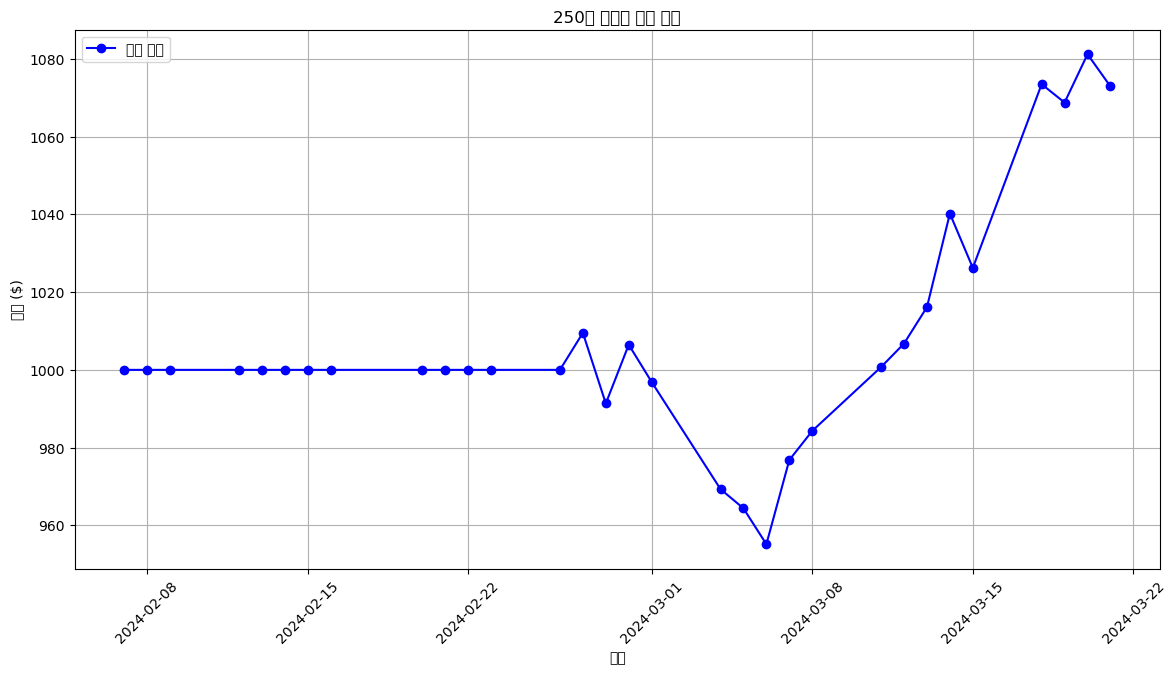

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 시각화 코드 예시
plt.figure(figsize=(14, 7))
plt.plot(dates, capitals, marker='o', linestyle='-', color='b', label='자본 변화')
plt.title('250일 동안의 자본 변화')
plt.xlabel('날짜')
plt.ylabel('자본 ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
